In [1]:
import sys
sys.path.append('.')
import anndata
import time, os, sys

import pandas as pd
import glob
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import scimap as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

Running SCIMAP  2.1.3


/Users/chiaraschiller/miniconda3/envs/scimap_local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# Create environment with
conda create -n scimap_env python=3.10 jupyter=1.1.1 pip -c conda-forge -c defaults
conda activate scimap_env
pip install git+https://github.com/SchapiroLabor/scimap_COZI.git

In [2]:
# Load in dataset. This is a .csv file with all samples concatenated together, either for symmetric or asymmetric data
path_to_csv = './tutorial_data/'
output_path_COZI_NEP = './../../tutorial_output_COZI.csv'

In [3]:

# read in all csv files in the example data (they all have ct, x and y coordinates) give them a new sample id column of their file names and row bind them all to one big dataframe
csv_files = glob.glob(os.path.join(path_to_csv, '*.csv'))

# Initialize an empty list to store individual DataFrames
data_frames = []

# Loop through the CSV files and process each one
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    sample_id = os.path.splitext(os.path.basename(file))[0]
    df['sample_id'] = sample_id
    data_frames.append(df)
    
# Concatenate all DataFrames into one big DataFrame
obs = pd.concat(data_frames, ignore_index=True)
obs

,x,y,ct,sample_id
0,0.00,0.00,1.00,ran_ab0_0.25_1
1,20.92,0.00,1.00,ran_ab0_0.25_1
2,44.38,0.00,0.00,ran_ab0_0.25_1
3,69.77,0.00,3.00,ran_ab0_0.25_1
4,96.62,0.00,2.00,ran_ab0_0.25_1
...,...,...,...,...
16093,22.53,468.98,2.00,self00_0.6_ab0_0.25_2
16094,939.06,247.90,2.00,self00_0.6_ab0_0.25_2
16095,385.69,814.39,3.00,self00_0.6_ab0_0.25_2
16096,657.91,543.04,2.00,self00_0.6_ab0_0.25_2


In [4]:
# create anndata object, randomly initialize marker values for this simulated dataset to comply with anndata format. Otehrwise use true markers for X

obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Load dataframe into anndata object
# dataframe for annotating the observations
obs = obs.astype({'ct':'string'})

# the data matrix 
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs

adata.obs

,x,y,ct,sample_id,D,E
0,0.00,0.00,1.0,ran_ab0_0.25_1,58,38
1,20.92,0.00,1.0,ran_ab0_0.25_1,43,30
2,44.38,0.00,0.0,ran_ab0_0.25_1,38,33
3,69.77,0.00,3.0,ran_ab0_0.25_1,12,24
4,96.62,0.00,2.0,ran_ab0_0.25_1,21,33
...,...,...,...,...,...,...
16093,22.53,468.98,2.0,self00_0.6_ab0_0.25_2,2,9
16094,939.06,247.90,2.0,self00_0.6_ab0_0.25_2,81,97
16095,385.69,814.39,3.0,self00_0.6_ab0_0.25_2,99,3
16096,657.91,543.04,2.0,self00_0.6_ab0_0.25_2,25,67


In [24]:
# run spatial interaction function in the COZI configuration with conditional normalization to look at neighbor preferences of phenotypes
# INFO: Changing normalization to 'total' runs spatial enrichment analysis (SEA). For running the original scimap spatial_interaction function, 
# create an environment based on the original scimap and run this function without the normalization parameter and run with knn or radius, or 
# check the delauany graph implementation in './../scripts/spatial_interaction_delaunay.py'.
# NEW: We added a new parameter for thresholding the minimum number of cell types that need to be present in a sample to consider for NEP calculation. Default is 10.
sm.tl.spatial_interaction(adata, 
                          phenotype='ct', 
                          x_coordinate='x', y_coordinate='y', 
                          imageid='sample_id', 
                          permutation = 300,
                          method='delaunay',
                          verbose=True,
                          normalization = 'conditional',
                          pval_method = 'zscore',
                          min_celltype_count = 10,
                          label='delauany_cozi')

Processing Image: ['ran_ab0_0.25_1']
Retaining 4 phenotypes with ≥ 10 cells
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['ran_ab0_0.25_3']
Retaining 4 phenotypes with ≥ 10 cells
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['ran_ab0_0.25_2']
Retaining 4 phenotypes with ≥ 10 cells
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['self00_0.45_ab0_0.25_3']
Retaining 4 phenotypes with ≥ 10 cells
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing I

AnnData object with n_obs × n_vars = 16098 × 2
    obs: 'x', 'y', 'ct', 'sample_id', 'D', 'E'
    uns: 'delauany_cozi'

In [25]:
# Extract and prepare interaction dataframe
save_df = (
    adata.uns['delauany_cozi']
    .assign(
        interaction=lambda df: df['phenotype'].astype(str) + "_" + df['neighbour_phenotype'].astype(str)
    )
    .drop(columns=['phenotype', 'neighbour_phenotype'])
    .set_index('interaction')
)

# Separate and clean zscore and cond_cell_ratio columns
zscore_df = save_df.filter(like="zscore_").rename(columns=lambda c: c.replace("zscore_", ""))
cond_ratio_df = save_df.filter(like="cond_cell_ratio_").rename(columns=lambda c: c.replace("cond_cell_ratio_", ""))

# Melt and merge into long format
merged_df = (
    pd.melt(zscore_df.reset_index(), id_vars="interaction", var_name="sample", value_name="zscore")
    .merge(
        pd.melt(cond_ratio_df.reset_index(), id_vars="interaction", var_name="sample", value_name="cond_cell_ratio"),
        on=["interaction", "sample"]
    )
    .dropna()
)


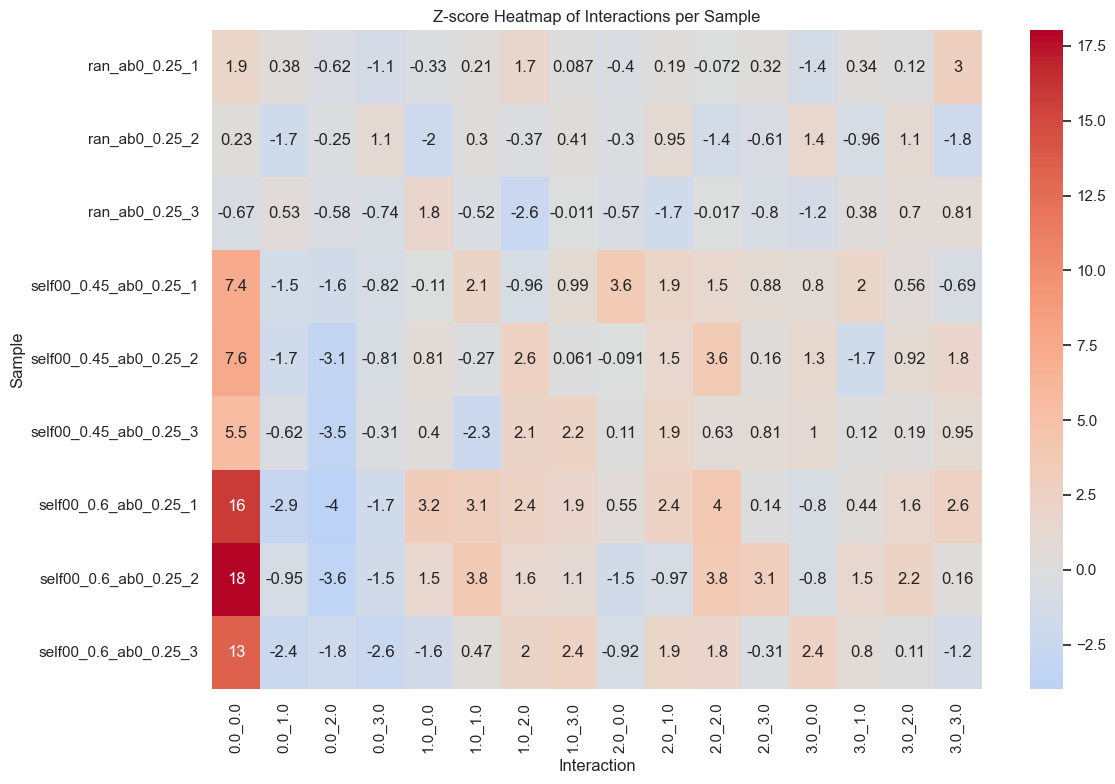

In [26]:
# Pivot the dataframe
heatmap_df = merged_df.pivot(index="sample", columns="interaction", values="zscore")

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="coolwarm", center=0, annot=True)

plt.title("Z-score Heatmap of Interactions per Sample")
plt.xlabel("Interaction")
plt.ylabel("Sample")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

One can see the differences in the NEP scores in the random (ran), weak (self00_0.45) and strong (self00_0.6) simulated cohorts of the self interaction of cell type '0'. 


For conditional normalization, it is valuable to also look at the ratio of cells, that are interacting with the other cell type in this interaction. Like that, one can interpret a zscore with knowing how many cells of the indec cell type contributed to that score. In the following, we plot the two informations, zscore and conditional cell ratio as dotplot.

/var/folders/79/cjwcycvd2_9dyfffbym60x200000gn/T/ipykernel_60049/4163919789.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



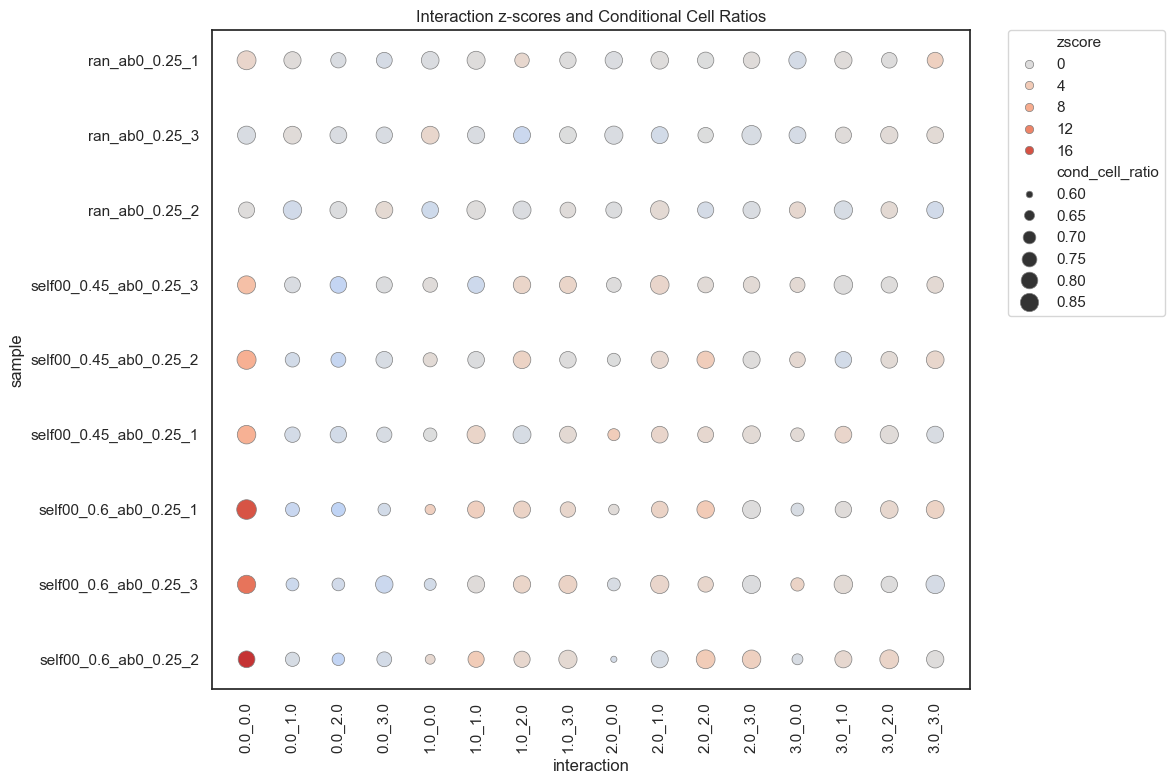

In [27]:
# Convert to native float types
merged_df["zscore"] = merged_df["zscore"].astype(float)
merged_df["cond_cell_ratio"] = merged_df["cond_cell_ratio"].astype(float)

# Set color normalization (fixed range for color mapping)
norm = mcolors.Normalize(vmin=-20, vmax=20)
cmap = cm.get_cmap("coolwarm")

# Plot dot plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=merged_df,
    x="interaction",
    y="sample",
    size="cond_cell_ratio",
    hue="zscore",
    hue_norm=norm,    
    palette="coolwarm",
    sizes=(20, 200),
    edgecolor='gray',
    linewidth=0.5

)


# Move legend outside
plt.legend(
    bbox_to_anchor=(1.05, 1),  # Adjust to move further out or up/down
    loc='upper left',
    borderaxespad=0.
)

plt.xticks(rotation=90)
plt.title("Interaction z-scores and Conditional Cell Ratios")
plt.tight_layout()  # Adjust layout so content doesn't get cut off
plt.show()

We can see, that the NEP zscores of cell types 1, 2 and 3 to cell type 0 are comparable. However, in the self interaction samples (bottom rows), the ratio of cells that interact with cell type 0 is reduced, as cell type 0 is mainly neighboring itself. This highlights the importance of looking at various scores that affect each other in a complex biological tissue. 